Samples (instances) are stored row-wise. Variables (attributes) of each sample are RNA-Seq gene expression levels measured by illumina HiSeq platform.
A dummy name (gene_XX) is given to each attribute. Check the original submission (https://www.synapse.org/#!Synapse:syn4301332), or the platform specs for the complete list of probes name. The attributes are ordered consitently with the original submission.

This collection of data is part of the RNA-Seq (HiSeq) PANCAN data set, it is a random extraction of gene expressions of patients having different types of tumor: BRCA, KIRC, COAD, LUAD and PRAD.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
from sklearn import metrics
import seaborn as sns
from sklearn.decomposition import PCA
import matplotlib.cm as cm
import scipy.cluster.hierarchy as shc
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn import cluster
from scipy.cluster.hierarchy import dendrogram, fclusterdata
from sklearn.preprocessing import LabelEncoder

import warnings
warnings.filterwarnings("ignore")

## (Optional) Preuzimanje podataka

In [2]:
import tarfile
import urllib

uci_tcga_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00401/"
archive_name = "TCGA-PANCAN-HiSeq-801x20531.tar.gz"

full_download_url = urllib.parse.urljoin(uci_tcga_url, archive_name)

In [3]:
r = urllib.request.urlretrieve (full_download_url, archive_name)

tar = tarfile.open(archive_name, "r:gz")
tar.extractall()
tar.close()

## Učitavanje podataka

In [2]:
datafile = "TCGA-PANCAN-HiSeq-801x20531/data.csv"
labels_file = "TCGA-PANCAN-HiSeq-801x20531/labels.csv"

In [3]:
data = pd.read_csv(datafile)
labels = pd.read_csv(labels_file)

## Analiza i Obrada Podataka

Ukratko: \
    - Nema NaN/Null vrednosti ni u jednoj od tabela podataka. \
    - Podaci 'data' sadrze obelezja koje imaju vrednost 0 za sve uzorke \
    - 20,532 obelezja i 801 uzoraka \
    - 5 razlicitih klasa karcinoma

**PRAD** - *Prostate adenocarcinoma* (karcinom prostate) \
**LUAD** - *Lung adenocarcinoma* (karcinom pluca) \
**BRCA** - *Breast invasive carcinoma* (invazivni karcinom dojke) \
**KIRC** - *Kidney renal clear cell carcinoma* (karcinom bubreznih celija) \
**COAD** - *Colon adenocarcinoma* (adenokarcinom debelog creva)

In [4]:
print("Broj uzoraka u 'data': " + str(data.shape[0]))
print("Broj obelezja u 'data': " + str(data.shape[1]))

print("\nBroj uzoraka u 'labels': " + str(labels.shape[0]))
print("Broj obelezja u 'labels': " + str(labels.shape[1]))

Broj uzoraka u 'data': 801
Broj obelezja u 'data': 20532

Broj uzoraka u 'labels': 801
Broj obelezja u 'labels': 2


In [5]:
data.head()

,Unnamed: 0,gene_0,gene_1,gene_2,gene_3,gene_4,gene_5,gene_6,gene_7,gene_8,...,gene_20521,gene_20522,gene_20523,gene_20524,gene_20525,gene_20526,gene_20527,gene_20528,gene_20529,gene_20530
0,sample_0,0.0,2.017209,3.265527,5.478487,10.431999,0.0,7.175175,0.591871,0.0,...,4.926711,8.210257,9.723516,7.220030,9.119813,12.003135,9.650743,8.921326,5.286759,0.0
1,sample_1,0.0,0.592732,1.588421,7.586157,9.623011,0.0,6.816049,0.000000,0.0,...,4.593372,7.323865,9.740931,6.256586,8.381612,12.674552,10.517059,9.397854,2.094168,0.0
2,sample_2,0.0,3.511759,4.327199,6.881787,9.870730,0.0,6.972130,0.452595,0.0,...,5.125213,8.127123,10.908640,5.401607,9.911597,9.045255,9.788359,10.090470,1.683023,0.0
3,sample_3,0.0,3.663618,4.507649,6.659068,10.196184,0.0,7.843375,0.434882,0.0,...,6.076566,8.792959,10.141520,8.942805,9.601208,11.392682,9.694814,9.684365,3.292001,0.0
4,sample_4,0.0,2.655741,2.821547,6.539454,9.738265,0.0,6.566967,0.360982,0.0,...,5.996032,8.891425,10.373790,7.181162,9.846910,11.922439,9.217749,9.461191,5.110372,0.0


In [ ]:
labels.head()

,Unnamed: 0,Class
0,sample_0,PRAD
1,sample_1,LUAD
2,sample_2,PRAD
3,sample_3,PRAD
4,sample_4,BRCA


In [ ]:
data.describe()

,gene_0,gene_1,gene_2,gene_3,gene_4,gene_5,gene_6,gene_7,gene_8,gene_9,...,gene_20521,gene_20522,gene_20523,gene_20524,gene_20525,gene_20526,gene_20527,gene_20528,gene_20529,gene_20530
count,801.000000,801.000000,801.000000,801.000000,801.000000,801.0,801.000000,801.000000,801.000000,801.000000,...,801.000000,801.000000,801.000000,801.000000,801.000000,801.000000,801.000000,801.000000,801.000000,801.000000
mean,0.026642,3.010909,3.095350,6.722305,9.813612,0.0,7.405509,0.499882,0.016744,0.013428,...,5.896573,8.765891,10.056252,4.847727,9.741987,11.742228,10.155271,9.590726,5.528177,0.095411
std,0.136850,1.200828,1.065601,0.638819,0.506537,0.0,1.108237,0.508799,0.133635,0.204722,...,0.746399,0.603176,0.379278,2.382728,0.533898,0.670371,0.580569,0.563849,2.073859,0.364529
min,0.000000,0.000000,0.000000,5.009284,8.435999,0.0,3.930747,0.000000,0.000000,0.000000,...,2.853517,6.678368,8.669456,0.000000,7.974942,9.045255,7.530141,7.864533,0.593975,0.000000
25%,0.000000,2.299039,2.390365,6.303346,9.464466,0.0,6.676042,0.000000,0.000000,0.000000,...,5.454926,8.383834,9.826027,3.130750,9.400747,11.315857,9.836525,9.244219,4.092385,0.000000
50%,0.000000,3.143687,3.127006,6.655893,9.791599,0.0,7.450114,0.443076,0.000000,0.000000,...,5.972582,8.784144,10.066385,5.444935,9.784524,11.749802,10.191207,9.566511,5.218618,0.000000
75%,0.000000,3.883484,3.802534,7.038447,10.142324,0.0,8.121984,0.789354,0.000000,0.000000,...,6.411292,9.147136,10.299025,6.637412,10.082269,12.177852,10.578561,9.917888,6.876382,0.000000
max,1.482332,6.237034,6.063484,10.129528,11.355621,0.0,10.718190,2.779008,1.785592,4.067604,...,7.771054,11.105431,11.318243,9.207495,11.811632,13.715361,11.675653,12.813320,11.205836,5.254133


- primecuju se geni koji su 0 za svaki uzorak

In [9]:
print("Ukupan broj nedostajucih (null|nan) vrednosti u 'data': " + str(data.isnull().sum().sum()))
print("Ukupan broj nedostajucih (null|nan) vrednosti u 'labels': " + str(labels.isnull().sum().sum()))

Ukupan broj nedostajucih (null|nan) vrednosti u 'data': 0
Ukupan broj nedostajucih (null|nan) vrednosti u 'labels': 0


In [10]:
print("Broj obelezja kod kojih su svi uzorci 0: " + str(data.loc[:, (data == 0).all()].columns.shape[0]))
print("\n> Obelezja kod kojih su svi uzorci 0:")
print(data.loc[:, (data == 0).all()].columns)

Broj obelezja kod kojih su svi uzorci 0: 267

> Obelezja kod kojih su svi uzorci 0:
Index(['gene_5', 'gene_23', 'gene_4370', 'gene_4808', 'gene_4809', 'gene_4814',
       'gene_4816', 'gene_4817', 'gene_4831', 'gene_5288',
       ...
       'gene_18908', 'gene_18909', 'gene_18910', 'gene_18911', 'gene_18914',
       'gene_18915', 'gene_19450', 'gene_19451', 'gene_19452', 'gene_19671'],
      dtype='object', length=267)


In [ ]:
# print("Broj obelezja pre izbacivanja onih kod kojih su svi uzorci 0: " + str(data.shape[1]))
# data.drop(data.loc[:, (data == 0).all()].columns, axis=1, inplace=True)
# print("Broj obelezja nakon izbacivanja onih kod kojih su svi uzorci 0: " + str(data.shape[1]))

Broj obelezja pre izbacivanja onih kod kojih su svi uzorci 0: 20533
Broj obelezja nakon izbacivanja onih kod kojih su svi uzorci 0: 20266


In [6]:
print("Moguce klase u 'labels':", labels.Class.unique())

Moguce klase u 'labels': ['PRAD' 'LUAD' 'BRCA' 'KIRC' 'COAD']


In [7]:
data['label'] = labels['Class']

In [13]:
data.head()

,Unnamed: 0,gene_0,gene_1,gene_2,gene_3,gene_4,gene_5,gene_6,gene_7,gene_8,...,gene_20522,gene_20523,gene_20524,gene_20525,gene_20526,gene_20527,gene_20528,gene_20529,gene_20530,label
0,sample_0,0.0,2.017209,3.265527,5.478487,10.431999,0.0,7.175175,0.591871,0.0,...,8.210257,9.723516,7.220030,9.119813,12.003135,9.650743,8.921326,5.286759,0.0,PRAD
1,sample_1,0.0,0.592732,1.588421,7.586157,9.623011,0.0,6.816049,0.000000,0.0,...,7.323865,9.740931,6.256586,8.381612,12.674552,10.517059,9.397854,2.094168,0.0,LUAD
2,sample_2,0.0,3.511759,4.327199,6.881787,9.870730,0.0,6.972130,0.452595,0.0,...,8.127123,10.908640,5.401607,9.911597,9.045255,9.788359,10.090470,1.683023,0.0,PRAD
3,sample_3,0.0,3.663618,4.507649,6.659068,10.196184,0.0,7.843375,0.434882,0.0,...,8.792959,10.141520,8.942805,9.601208,11.392682,9.694814,9.684365,3.292001,0.0,PRAD
4,sample_4,0.0,2.655741,2.821547,6.539454,9.738265,0.0,6.566967,0.360982,0.0,...,8.891425,10.373790,7.181162,9.846910,11.922439,9.217749,9.461191,5.110372,0.0,BRCA


In [8]:
df = data.drop('Unnamed: 0', axis=1)

In [9]:
df.rename(columns={'label': 'class'}, inplace=True)

In [10]:
df.head()

,gene_0,gene_1,gene_2,gene_3,gene_4,gene_5,gene_6,gene_7,gene_8,gene_9,...,gene_20522,gene_20523,gene_20524,gene_20525,gene_20526,gene_20527,gene_20528,gene_20529,gene_20530,class
0,0.0,2.017209,3.265527,5.478487,10.431999,0.0,7.175175,0.591871,0.0,0.0,...,8.210257,9.723516,7.220030,9.119813,12.003135,9.650743,8.921326,5.286759,0.0,PRAD
1,0.0,0.592732,1.588421,7.586157,9.623011,0.0,6.816049,0.000000,0.0,0.0,...,7.323865,9.740931,6.256586,8.381612,12.674552,10.517059,9.397854,2.094168,0.0,LUAD
2,0.0,3.511759,4.327199,6.881787,9.870730,0.0,6.972130,0.452595,0.0,0.0,...,8.127123,10.908640,5.401607,9.911597,9.045255,9.788359,10.090470,1.683023,0.0,PRAD
3,0.0,3.663618,4.507649,6.659068,10.196184,0.0,7.843375,0.434882,0.0,0.0,...,8.792959,10.141520,8.942805,9.601208,11.392682,9.694814,9.684365,3.292001,0.0,PRAD
4,0.0,2.655741,2.821547,6.539454,9.738265,0.0,6.566967,0.360982,0.0,0.0,...,8.891425,10.373790,7.181162,9.846910,11.922439,9.217749,9.461191,5.110372,0.0,BRCA


In [11]:
print("Broj uzoraka po klasama:")
print(df.value_counts('class'))

Broj uzoraka po klasama:
class
BRCA    300
KIRC    146
LUAD    141
PRAD    136
COAD     78
dtype: int64


In [12]:
print("Broj uzoraka sa istim vrednostima za sva obelezja: ", df.duplicated().sum())

Broj uzoraka sa istim vrednostima za sva obelezja:  0


In [13]:
X = df.iloc[:, :-1].copy()
y = df.iloc[:, -1].copy()
target_names = df['class'].unique()

## Standardizacija podataka

In [14]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

scaler = StandardScaler()
X_std = scaler.fit_transform(X)

In [101]:
# test
minmax = MinMaxScaler()
X_mm = minmax.fit_transform(X)

## Pomoćne funkcije

In [15]:
def metric_eval(X, y, algoType, algoName):
  print("Evaluacija rezultata klasterovanja primenom: " + algoName + " algoritma")
  print("ARI: ", metrics.adjusted_rand_score(y, algoType.labels_))
  print('SIL: ', metrics.silhouette_score(X, algoType.labels_, metric='euclidean'))
  print('CH: ', metrics.calinski_harabasz_score(X, algoType.labels_))
  print('DB: ', metrics.davies_bouldin_score(X, algoType.labels_))

In [16]:
def display_scree_plot(pca, start, end):
    '''Scree plot za pca'''

    scree = pca.explained_variance_ratio_[start:end]*100
    print("Ukupna objasnjena varijansa: ", pca.explained_variance_ratio_[start:end].sum())
    print()

    rotX = 0
    num = end - start
    if num > 70:
      rotX = 90

    plt.figure(figsize=(16, 8))
    plt.bar(np.arange(len(scree))+1, scree, width=0.5, align='edge')
    plt.xticks(np.arange(1, len(scree)+1), np.arange(1, len(scree)+1), rotation = rotX)
    plt.xlabel("Number of principal components")
    plt.ylabel("Percentage explained variance (%)")
    plt.title("Scree plot")
    plt.show(block=False)

In [17]:
def pca_plot(X_pca, y, target_names):
  plt.figure(figsize=(16,9))
  for i in target_names:
      plt.scatter(X_pca[y == i, 0], X_pca[y == i, 1], alpha=0.5, label=i)
  plt.legend()
  plt.title('PCA of dataset')
  plt.show()

## PCA - redukcija dimenzionalnosti

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


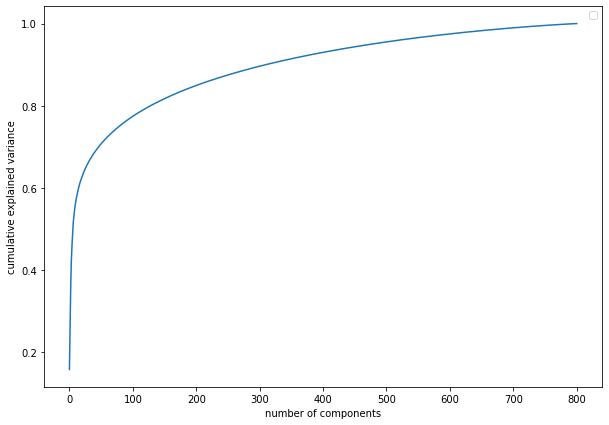

In [25]:
pca = PCA(n_components=None).fit(X)
plt.figure(figsize=(12, 7))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.legend()
plt.show()

Ukupna objasnjena varijansa:  0.6369822788069395



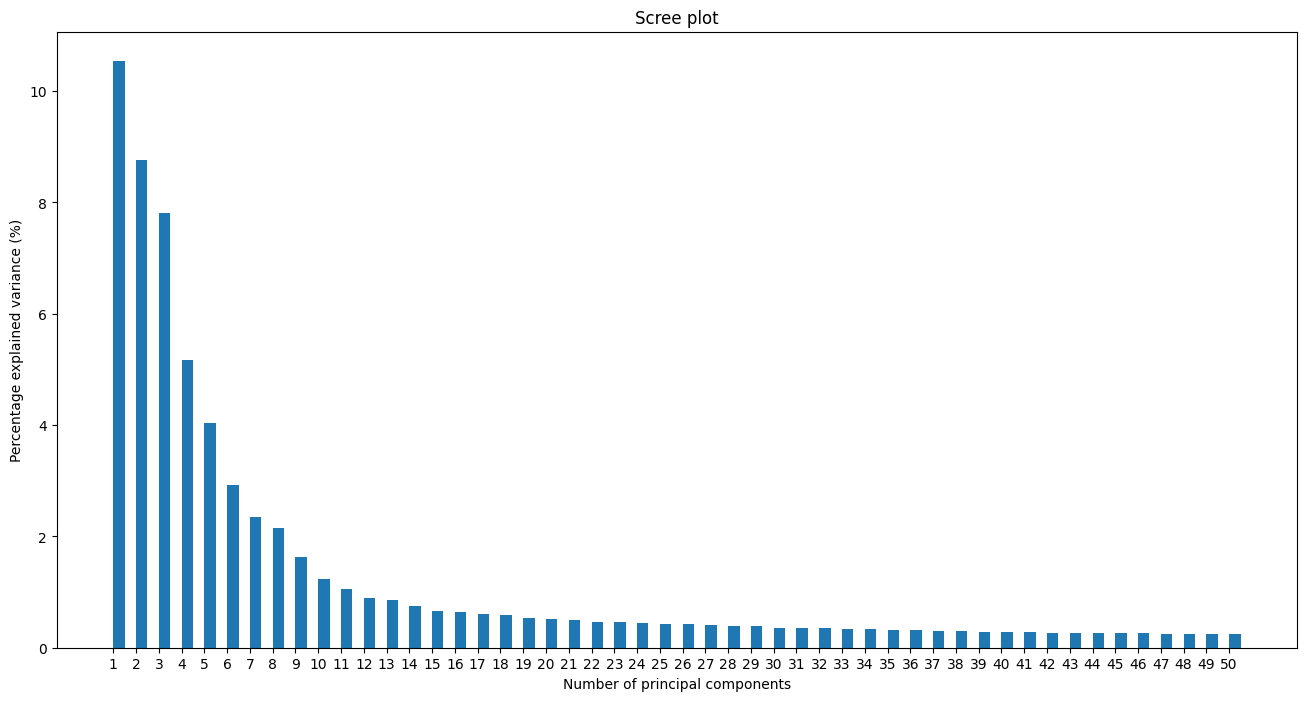

In [68]:
start = 0
end = 50
display_scree_plot(pca, start, end)

In [26]:
pca = PCA(n_components=None).fit(X)
pca_std = PCA(n_components=None).fit(X_std)

X_pca = pca.transform(X)
X_pca_std = pca_std.transform(X_std)

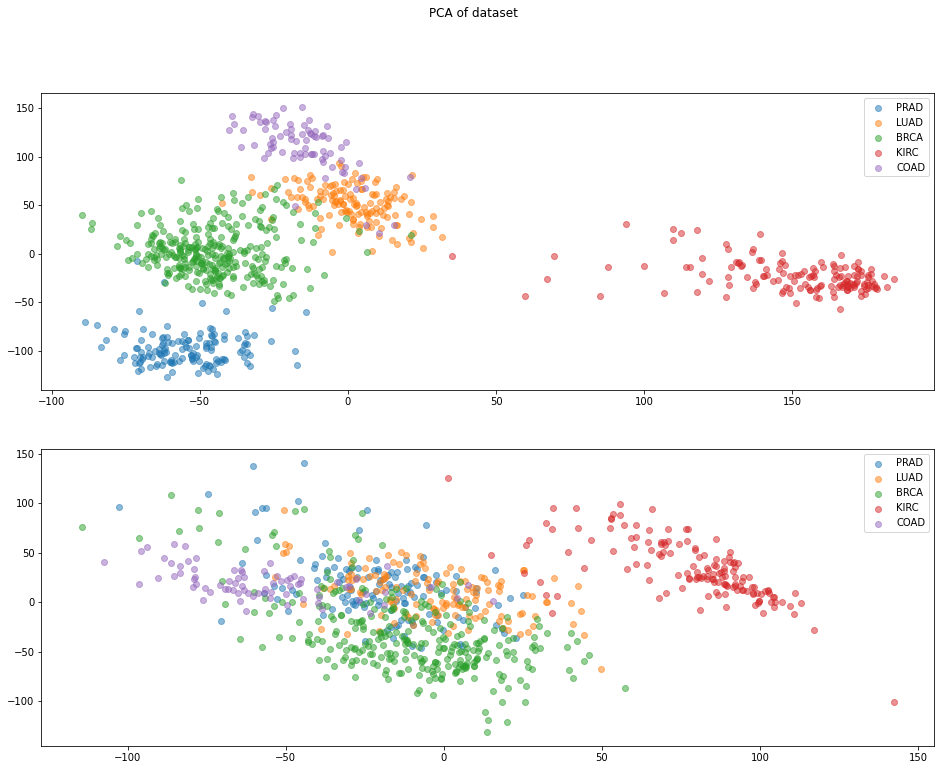

In [27]:
fig, axs = plt.subplots(2, figsize=(16, 12))
fig.suptitle('PCA of dataset')

for i in target_names:
    axs[0].scatter(X_pca[y == i, 0], X_pca[y == i, 1], alpha=0.5, label=i)

for i in target_names:
    axs[1].scatter(X_pca_std[y == i, 0], X_pca_std[y == i, 1], alpha=0.5, label=i)

# fig.legend()
axs[0].legend()
axs[1].legend()

plt.show()

## K-Means

In [28]:
def kmeans_algo(X, clusters = 4, num_init = 50, iter = 300, type_init='k-means++', state=42):
  kmeans = KMeans(n_clusters = clusters, 
                  n_init = num_init, 
                  max_iter = iter, 
                  init = type_init,
                  random_state = state)
  
  start = time.time()
  kmeans_labels = kmeans.fit_predict(X)
  estimated_time = time.time() - start

  return kmeans, kmeans_labels, estimated_time

### Original dimension

Primena K-Means algoritma nad originalnim skupom podataka, pre redukcije dimenzionalnosti. \
Prvo je primenjen algoritam nad nestandardizovanim podacima, nakon toga nad standardizovanim.

In [30]:
kmeans, kmeans_labels, est_time = kmeans_algo(X, clusters = 4, num_init = 50, iter = 500, type_init='k-means++', state = 42)
print("Time taken [no-std]: ", est_time)

kmeans_std, kmeans_labels_std, est_time_std = kmeans_algo(X_std, clusters = 4, num_init = 50, iter = 500, type_init='k-means++', state = 42)
print("Time taken [std]: ", est_time_std)

Time taken [no-std]:  34.450865745544434
Time taken [std]:  47.23221039772034


In [33]:
print("Orig dataset")
metric_eval(X, y, kmeans, 'K-Means')

print("\nStd dataset")
metric_eval(X_std, y, kmeans_std, 'K-Means')

Orig dataset
Evaluacija rezultata klasterovanja primenom: K-Means algoritma
ARI:  0.9029314830724121
SIL:  0.20127932414890432
CH:  129.49970071195852
DB:  2.003426285665195

Std dataset
Evaluacija rezultata klasterovanja primenom: K-Means algoritma
ARI:  0.7148064967138005
SIL:  0.11576099889803138
CH:  69.90190381220776
DB:  2.6698825789355167


### Reduced dimension

#### 2 dimensions (~20% explained variance)

Primena K-means algoritma nakon primenjene redukcije dimenzionalnosti (na 2D)

In [34]:
pca = PCA(n_components=2)
pca.fit(X)
X_pca = pca.transform(X)

In [35]:
kmeans, _, est_time_pca = kmeans_algo(X_pca)
print("Time taken: ", est_time_pca)

Time taken:  0.2770571708679199


In [36]:
metric_eval(X_pca, y, kmeans, 'K-Means [2D]')

Evaluacija rezultata klasterovanja primenom: K-Means [2D] algoritma
ARI:  0.7771606488576661
SIL:  0.608478335278385
CH:  2573.4826142485363
DB:  0.5230522672384423


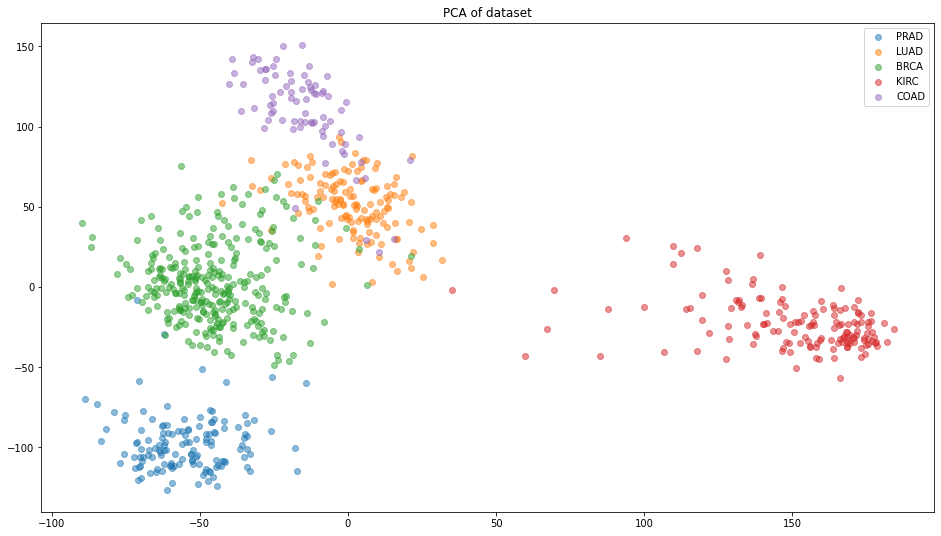

In [37]:
pca_plot(X_pca, y, target_names)

#### 200 dimensions (~85% variance)

In [38]:
pca = PCA(n_components=200)
pca.fit(X)
X_pca = pca.transform(X)

In [39]:
kmeans, _, est_time_pca = kmeans_algo(X_pca)
print("Time taken: ", est_time_pca)

Time taken:  5.506719350814819


In [40]:
metric_eval(X_pca, y, kmeans, 'K-Means [200D]')

Evaluacija rezultata klasterovanja primenom: K-Means [200D] algoritma
ARI:  0.9029314830724121
SIL:  0.24896213674729178
CH:  167.65451993779152
DB:  1.7521621882828753


### Silhouette Analysis

Primenom siluet analize mozemo pronaci optimalan broj klustera za K-Means algoritam ukoliko prethodno nemamo informaciju o klasama (y).

Evaluacija rezultata klasterovanja primenom: Kmeans (n_clusters = 2) algoritma
ARI:  0.23590734794341528
SIL:  0.6162707785281902
CH:  955.5087946123491
DB:  0.454541525589318

Evaluacija rezultata klasterovanja primenom: Kmeans (n_clusters = 3) algoritma
ARI:  0.4554835438351347
SIL:  0.5530074890593368
CH:  1667.3995197896716
DB:  0.6055761934261273

Evaluacija rezultata klasterovanja primenom: Kmeans (n_clusters = 4) algoritma
ARI:  0.7771606488576661
SIL:  0.6084783352449142
CH:  2573.4826172605985
DB:  0.5230522672177753

Evaluacija rezultata klasterovanja primenom: Kmeans (n_clusters = 5) algoritma
ARI:  0.8071999590617023
SIL:  0.6095934263251379
CH:  2968.4716750024213
DB:  0.5125613595466197

Evaluacija rezultata klasterovanja primenom: Kmeans (n_clusters = 6) algoritma
ARI:  0.6724717472905669
SIL:  0.5438945705506542
CH:  2879.2245162260733
DB:  0.6252709233590157

Evaluacija rezultata klasterovanja primenom: Kmeans (n_clusters = 7) algoritma
ARI:  0.6285173182434091
SIL:  0

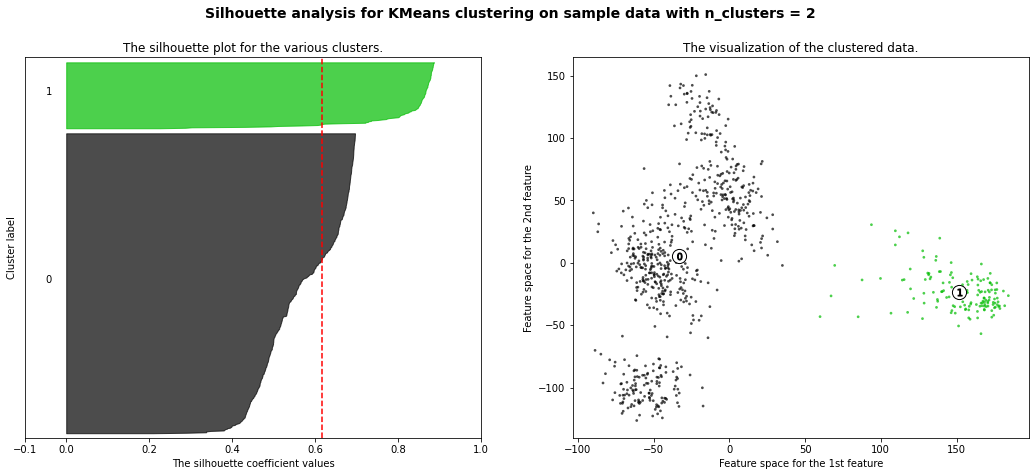

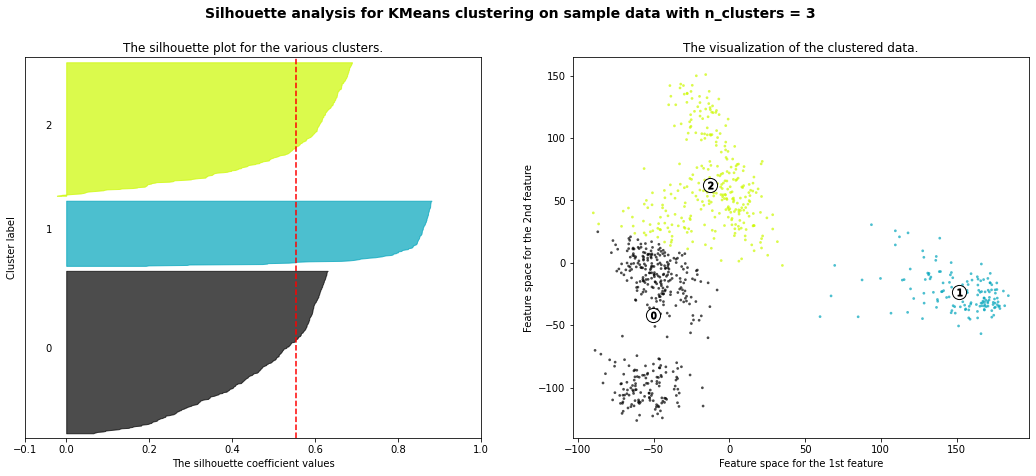

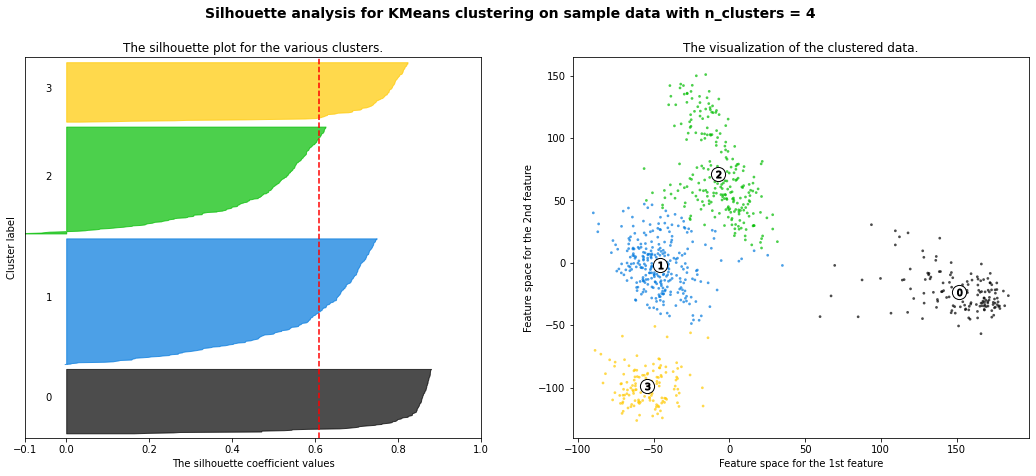

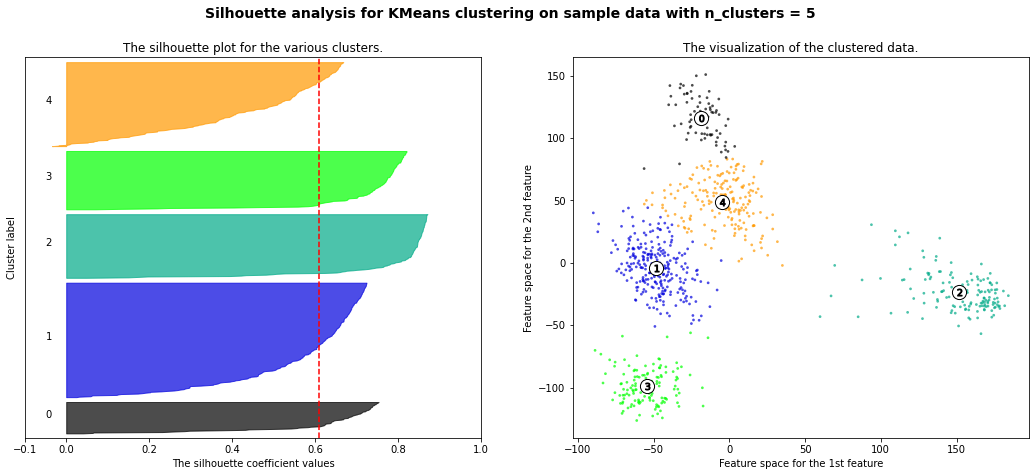

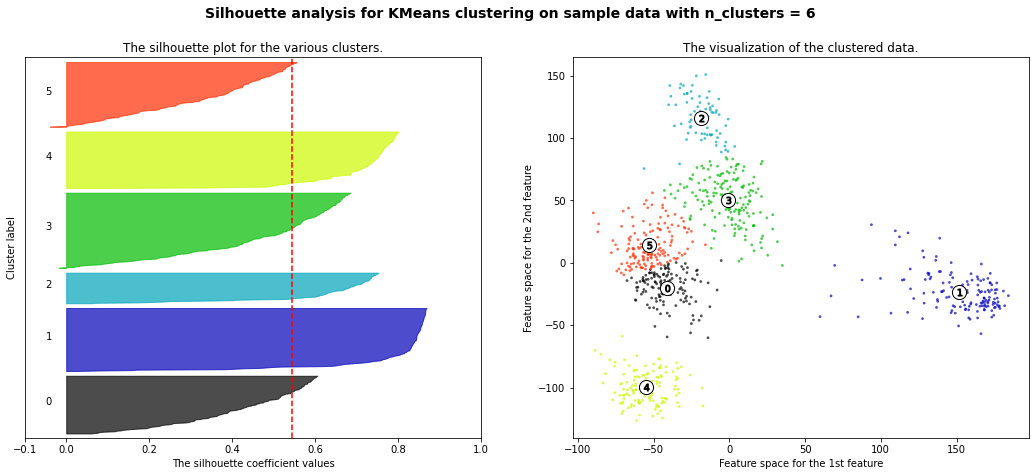

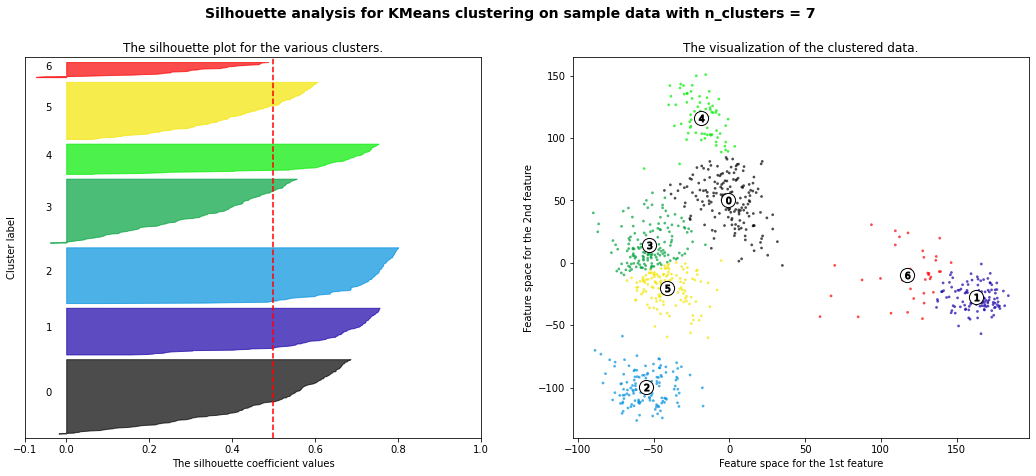

In [41]:

pca = PCA(n_components=2)
pca.fit(X)
X_pca = pca.transform(X)

for n_clusters in range(2, 8):

  fig, (ax1, ax2) = plt.subplots(1, 2)
  fig.set_size_inches(18, 7)

  ax1.set_xlim([-0.1, 1])

  ax1.set_ylim([0, len(X_pca) + (n_clusters + 1) * 10])

  cluster, cluster_labels, est_time_std = kmeans_algo(X_pca, clusters = n_clusters)
  silhouette_avg = metrics.silhouette_score(X_pca, cluster_labels)

  text_cluster = "Kmeans (n_clusters = " + str(n_clusters) + ")"
  metric_eval(X_pca, y, cluster, text_cluster)
  print()
  
  sample_silhouette_values = metrics.silhouette_samples(X_pca, cluster_labels, metric='euclidean')
  y_lower = 10

  for i in range(n_clusters):
    # Aggregate the silhouette scores for samples belonging to
    # cluster i, and sort them
    ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

    ith_cluster_silhouette_values.sort()

    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    color = cm.nipy_spectral(float(i) / n_clusters)
    ax1.fill_betweenx(
      np.arange(y_lower, y_upper),
      0,
      ith_cluster_silhouette_values,
      facecolor=color,
      edgecolor=color,
      alpha=0.7,
    )

    # Label the silhouette plots with their cluster numbers at the middle
    ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

    # Compute the new y_lower for next plot
    y_lower = y_upper + 10  # 10 for the 0 samples


  ax1.set_title("The silhouette plot for the various clusters.")
  ax1.set_xlabel("The silhouette coefficient values")
  ax1.set_ylabel("Cluster label")

  # The vertical line for average silhouette score of all the values
  ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

  ax1.set_yticks([])  # Clear the yaxis labels / ticks
  ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

  # 2nd Plot showing the actual clusters formed
  colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
  ax2.scatter(
    X_pca[:, 0], X_pca[:, 1], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
  )

  # Labeling the clusters
  centers = cluster.cluster_centers_
  # Draw white circles at cluster centers
  ax2.scatter(
    centers[:, 0],
    centers[:, 1],
    marker="o",
    c="white",
    alpha=1,
    s=200,
    edgecolor="k",
  )

  for i, c in enumerate(centers):
    ax2.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")

  ax2.set_title("The visualization of the clustered data.")
  ax2.set_xlabel("Feature space for the 1st feature")
  ax2.set_ylabel("Feature space for the 2nd feature")

  plt.suptitle(
    "Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
    % n_clusters,
    fontsize=14,
    fontweight="bold",
  )

plt.show()

Ukoliko ne bismo prethodno znali koliko klasa nasi podaci sadrze, bilo bi potrebno izvrsiti dodatne analize pored siluet analize za odredjivanje optimalnog broja klastera. (Npr Elbow Method, Gap Statistics, itd.)

Elbow method i gap statistic primenjeni nad X_pca podacima radi brzeg izvrsenja

### Elbow Method

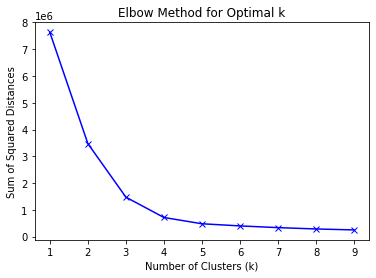

In [45]:
sse = []

# Define the range of possible number of clusters
k_range = range(1, 10)

# Iterate over the range of clusters and compute SSE for each k
for k in k_range:
    # kmeans, _, _ = kmeans_algo(X_pca, clusters=k)
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_pca)
    sse.append(kmeans.inertia_)  # SSE is available as inertia_ attribute


# Plot the SSE for each value of k
plt.plot(k_range, sse, 'bx-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Sum of Squared Distances')
plt.title('Elbow Method for Optimal k')
plt.show()

### Gap Statistics

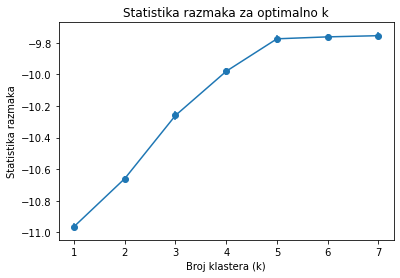

In [50]:
k_range = range(1, 8)

# Inicijalizacija nizova za čuvanje unutarklaster rasipanja i statistike razmaka
wcss = np.zeros(len(k_range))
gap_stats = np.zeros(len(k_range))

# Izračunavanje unutarklaster rasipanja za svaku vrednost k
for i, k in enumerate(k_range):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_pca)
    wcss[i] = kmeans.inertia_

# Generisanje referentne distribucije za poređenje
nrefs = 10  # Broj referentnih skupova podataka
max_k = len(k_range)
ref_disps = np.zeros((max_k, nrefs))
for i, k in enumerate(k_range):
    for j in range(nrefs):
        # Generisanje referentnog skupa podataka
        random_data = np.random.random_sample(size=X_pca.shape)
        # Fitovanje K-sredina na referentnom skupu podataka
        kmeans_ref = KMeans(n_clusters=k, random_state=42)
        kmeans_ref.fit(random_data)
        ref_disps[i, j] = kmeans_ref.inertia_

# Izračunavanje statistike razmaka
for i in range(len(k_range)):
    gap_stats[i] = np.mean(np.log(ref_disps[i])) - np.log(wcss[i])

# Izračunavanje standardne devijacije referentnih rasipanja
sd = np.std(np.log(ref_disps), axis=1)

# Izračunavanje greške za statistiku razmaka
error_bars = sd * np.sqrt(1 + 1.0 / nrefs)

# Prikazivanje statistike razmaka sa greškama
plt.errorbar(list(k_range), gap_stats, yerr=error_bars, marker='o')
plt.xlabel('Broj klastera (k)')
plt.ylabel('Statistika razmaka')
plt.title('Statistika razmaka za optimalno k')
plt.show()


## Agglomerative

In [58]:
pca = PCA(0.9)
pca.fit(X)
X_pca = pca.transform(X)

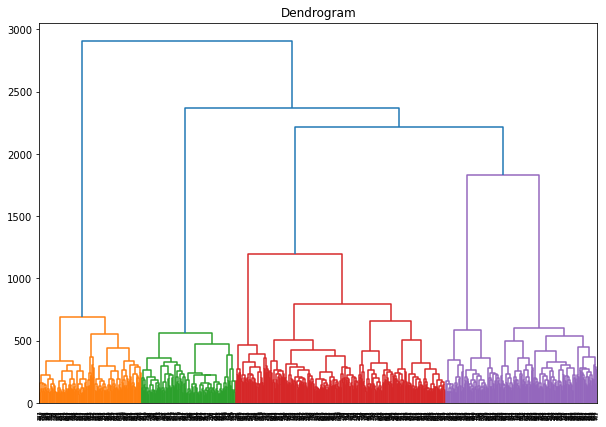

In [59]:
plt.figure(figsize=(10, 7))
plt.title("Dendrogram")
dend = shc.dendrogram(shc.linkage(X_pca, method='ward', metric='euclidean'))
plt.show()

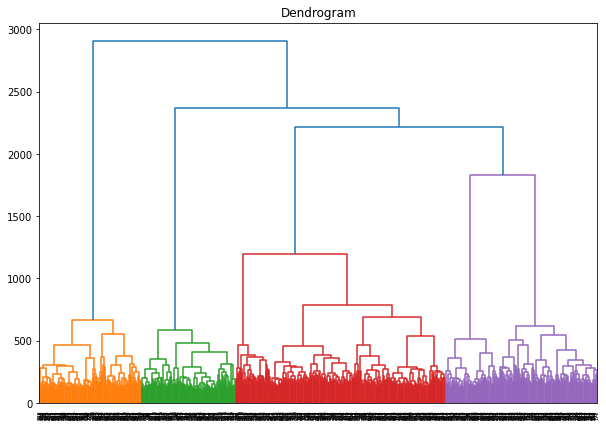

In [53]:
plt.figure(figsize=(10, 7))
plt.title("Dendrogram")
dend = shc.dendrogram(shc.linkage(X, method='ward', metric='euclidean'))
plt.show()

Agolmerativno klasterovanje nad originalnim podacima (n_clusters=5 zbog prethodno obavljene analize + znamo da ima 5 klasa)

In [62]:
cluster = AgglomerativeClustering(n_clusters=5, affinity='euclidean', linkage='ward')
cluster.fit_predict(X)

array([2, 3, 2, 2, 0, 2, 1, 2, 0, 2, 0, 1, 2, 0, 0, 0, 3, 1, 1, 2, 0, 1,
       3, 0, 1, 3, 4, 0, 0, 0, 0, 0, 1, 0, 2, 0, 1, 3, 0, 0, 1, 2, 2, 1,
       1, 0, 2, 4, 0, 3, 0, 3, 0, 2, 4, 0, 0, 4, 1, 0, 3, 1, 0, 3, 2, 4,
       0, 2, 1, 0, 1, 0, 0, 3, 0, 3, 0, 1, 2, 4, 0, 2, 0, 0, 2, 2, 0, 0,
       1, 0, 2, 2, 0, 0, 0, 2, 4, 0, 2, 0, 0, 1, 0, 1, 3, 1, 3, 4, 3, 3,
       2, 0, 3, 2, 0, 1, 1, 1, 0, 0, 3, 1, 3, 0, 2, 2, 2, 0, 1, 0, 4, 0,
       4, 0, 0, 1, 3, 0, 1, 4, 0, 2, 0, 1, 3, 4, 2, 0, 3, 3, 3, 3, 0, 0,
       3, 0, 0, 2, 2, 3, 2, 3, 1, 0, 2, 3, 4, 1, 3, 0, 1, 3, 0, 3, 0, 0,
       0, 2, 0, 1, 4, 1, 0, 2, 2, 2, 3, 3, 0, 3, 3, 1, 3, 2, 3, 0, 0, 0,
       3, 3, 0, 1, 1, 1, 1, 2, 0, 2, 0, 3, 3, 0, 2, 0, 2, 0, 0, 0, 3, 0,
       1, 3, 1, 1, 3, 0, 1, 2, 0, 3, 3, 2, 4, 0, 1, 2, 1, 4, 0, 1, 1, 3,
       2, 2, 3, 3, 1, 0, 0, 4, 0, 2, 4, 0, 2, 1, 2, 2, 2, 0, 4, 4, 3, 4,
       4, 2, 3, 0, 0, 1, 1, 0, 4, 2, 1, 2, 0, 0, 1, 0, 0, 0, 0, 3, 3, 0,
       0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 3, 2, 0,

In [63]:
metric_eval(X, y, cluster, 'Agglomerative')

Evaluacija rezultata klasterovanja primenom: Agglomerative algoritma
ARI:  0.9869824601399302
SIL:  0.22475991424365693
CH:  124.79659816424767
DB:  1.830705019555889


In [64]:
pca = PCA(0.8)
pca.fit(X)
X_pca = pca.transform(X)

cluster = AgglomerativeClustering(n_clusters=5, affinity='euclidean', linkage='ward')
cluster.fit_predict(X_pca)

metric_eval(X_pca, y, cluster, 'Agglomerative')

Evaluacija rezultata klasterovanja primenom: Agglomerative algoritma
ARI:  0.9870179303904618
SIL:  0.2956884891742354
CH:  184.74130984413324
DB:  1.477661896200797


In [65]:
for i in range(2, 7):

  cluster = AgglomerativeClustering(n_clusters=i, affinity='euclidean', linkage='ward')
  cluster.fit_predict(X_pca)

  metric_eval(X_pca, y, cluster, 'Agglomerative cluster=' + str(i))
  print()

Evaluacija rezultata klasterovanja primenom: Agglomerative cluster=2 algoritma
ARI:  0.23900133115844793
SIL:  0.2224908641068987
CH:  178.3698953977079
DB:  1.418354710371318

Evaluacija rezultata klasterovanja primenom: Agglomerative cluster=3 algoritma
ARI:  0.5117729569307613
SIL:  0.22451552291480306
CH:  173.58061933613112
DB:  1.5098300558692992

Evaluacija rezultata klasterovanja primenom: Agglomerative cluster=4 algoritma
ARI:  0.9020468456742174
SIL:  0.2652617757760414
CH:  183.61900594294121
DB:  1.6695266077867437

Evaluacija rezultata klasterovanja primenom: Agglomerative cluster=5 algoritma
ARI:  0.9870179303904618
SIL:  0.2956884891742354
CH:  184.74130984413324
DB:  1.477661896200797

Evaluacija rezultata klasterovanja primenom: Agglomerative cluster=6 algoritma
ARI:  0.8881833216174423
SIL:  0.30077569544163685
CH:  166.93297741991043
DB:  1.542222962828354



### Dendogram

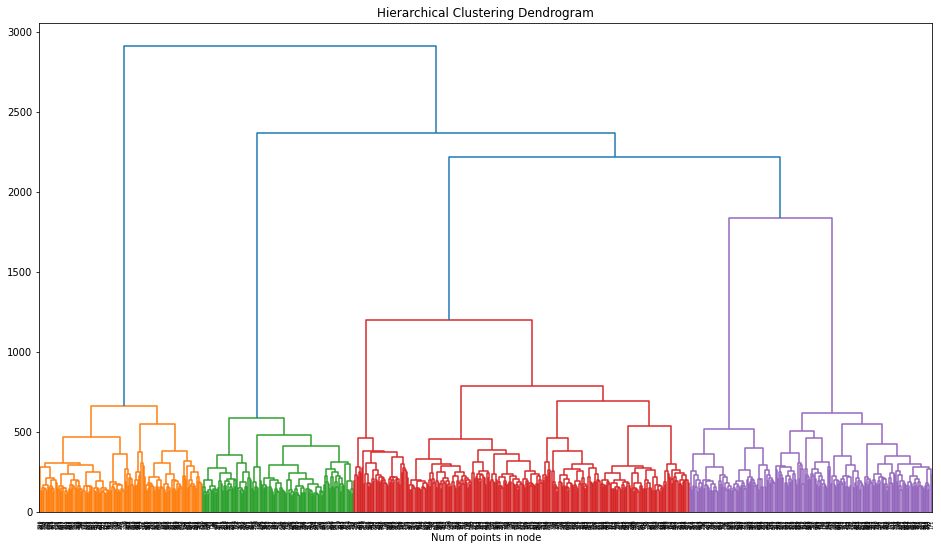

In [69]:
def plot_dendrogram(model, **kwargs):
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)

    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot dendrogram
    dendrogram(linkage_matrix, **kwargs)

model = AgglomerativeClustering(n_clusters=None, distance_threshold=0, affinity='euclidean', linkage='ward')

model = model.fit(X)
plt.figure(figsize=(16, 9))
plt.title("Hierarchical Clustering Dendrogram")
# plot the top three levels of the dendrogram
plot_dendrogram(model, truncate_mode="level", p=30)
plt.xlabel("Num of points in node")
plt.show()